**done locally on laptop**

In [1]:
import numpy
import gdal
import osr
import glob
import xarray
import re
import pprint

import cartopy
import cmocean
import matplotlib.pyplot as mp

list the files in the directory

In [2]:
!ls ../modis_data/MOD11A1.A2017232_data/*h{28,29,30,31,32}*v{08,09,10}*.hdf

../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h28v08.006.2017233092034.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h28v09.006.2017233092035.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h28v10.006.2017233092044.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h29v08.006.2017233092040.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h29v09.006.2017233092041.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h29v10.006.2017233092038.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h30v08.006.2017233092036.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h30v09.006.2017233092037.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h30v10.006.2017233092053.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h31v08.006.2017233092033.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h31v09.006.2017233092033.hdf
../modis_data/MOD11A1.A2017232_data/MOD11A1.A2017232.h31v10.006.2017233092042.hdf
../modis_data/MO

open all files as a separate gdal dataset

(store in list)

In [3]:
file_list_all = sorted(glob.glob('../modis_data/MOD11A1.A2017232_data/*.hdf'))
reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
file_list = [filename for filename in file_list_all if re.match(reg_exp, filename)]
gdal_datasets = [gdal.Open(f) for f in file_list]

open the specific files you want (e.g., day and night land surface temps., quality control data)

(store in list)

In [4]:
gdal_lst_day_data = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]
gdal_lst_night_data = [ds.GetSubDatasets()[4][0] for ds in gdal_datasets]
gdal_qc_data = [ds.GetSubDatasets()[1][0] for ds in gdal_datasets]

use ```gdal.BuildVRT``` to create a mosaic of the files

(done for each list of gdal subdatasets)

In [5]:
lst_day_mosaic = gdal.BuildVRT('../vrt_files/gdal_lst_day_mosaic.vrt', gdal_lst_day_data)
lst_mosaic_day_data = lst_day_mosaic.ReadAsArray()

lst_night_mosaic = gdal.BuildVRT('../vrt_files/gdal_lst_night_mosaic.vrt', gdal_lst_night_data)
lst_mosaic_night_data = lst_night_mosaic.ReadAsArray()

qc_mosaic = gdal.BuildVRT('../vrt_files/gdal_qc_mosaic.vrt', gdal_qc_data)
qc_mosaic_data = qc_mosaic.ReadAsArray()

get the geotransform info from one of these data sets

In [6]:
lst_geotrans = lst_day_mosaic.GetGeoTransform()

use the geotransform info to create a data_extent tuple for cartopy

In [7]:
data_extent = (lst_geotrans[0], \
               lst_geotrans[0] + lst_day_mosaic.RasterXSize*lst_geotrans[1], \
               lst_geotrans[3] + lst_day_mosaic.RasterYSize*lst_geotrans[5], \
               lst_geotrans[3])

plot on original projection

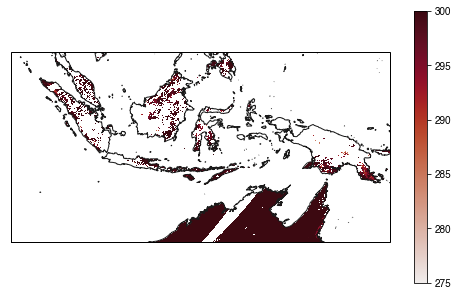

In [8]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

field = lst_mosaic_day_data*.02
field[field==0] = numpy.nan

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=275,vmax=300,cmap=cmocean.cm.amp)
ax.coastlines(resolution='10m', color='0.1')

mp.colorbar(image)

plot nighttime temperature from original projection

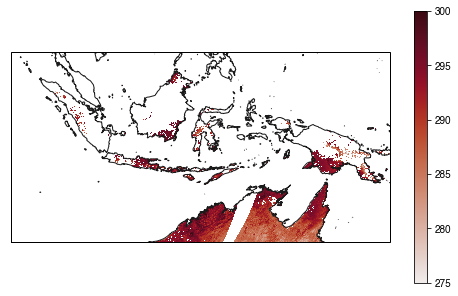

In [9]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

field = lst_mosaic_night_data*.02
field[field==0] = numpy.nan

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=275,vmax=300,cmap=cmocean.cm.amp)
ax.coastlines(resolution='10m', color='0.1')

#ax.set_extent([94,154,-12,10])
mp.colorbar(image)

plot on new projection (this time, plotting quality control data):

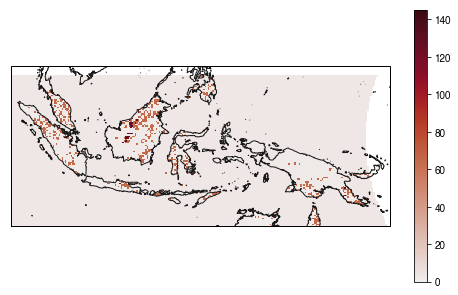

In [10]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=120, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

field = qc_mosaic_data

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  cmap=cmocean.cm.amp)
ax.coastlines(resolution='10m', color='0.1')

ax.set_extent([94,154,-12,10])
mp.colorbar(image)